## Imports

In [2]:
import plotly.express as px
from dash import Dash, html, dcc, Input, Output, callback
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pycountry
import geopandas as gpd
import json

In [3]:
iris = px.data.iris()
fig  = px.scatter(iris, x="sepal_length", y="petal_length",
                  color="species", title="Iris scatter")

In [4]:
app = Dash(__name__)   # "inline", "external", or "jupyterlab"

app.layout = html.Div(
    [
        dcc.Dropdown(
            options=[{"label": s, "value": s} for s in iris["species"].unique()],
            value="setosa",
            id="species"
        ),
        dcc.Graph(id="graph", figure=fig)
    ]
)

In [9]:

@callback(Output("graph", "figure"), Input("species", "value"))
def update(selected):
    return px.scatter(
        iris[iris["species"] == selected],
        x="sepal_length", y="petal_length",
        color="species", title=f"Iris scatter – {selected}"
    )

app.run(debug=True, port=8051, jupyter_mode="inline")

## Load Data

In [10]:
filename = "World_Wide_Unicorn_Startups.csv"
unicorn = pd.read_csv(f"../data/{filename}")
unicorn.head()

,Company,Valuation,Country,City,Industry,Year
0,Red Ventures,1.00,United States,Fort Mill,Other,2015
1,Tanium,9.00,United States,Kirkland,Cybersecurity,2015
2,Planet Labs,2.20,United States,San Francisco,Other,2015
3,Illumio,2.75,United States,Sunnyvale,Cybersecurity,2015
4,Infinidat,1.60,United States,Waltham,Hardware,2015


In [11]:
filename = "QOL.csv"
qol_gdp = pd.read_csv(f"../data/{filename}")
qol_gdp.head()

,Country,Quality of Life Index,Purchasing Power Index,Cost of Living Index,Property Price to Income Ratio,Year,GDP per Capita
0,Argentina,77.0,59.4,67.1,11.6,2015,14833.199680
1,Australia,180.8,110.4,99.3,7.1,2015,52009.802759
2,Austria,182.6,104.6,76.9,9.6,2015,43908.420277
3,Belgium,136.0,86.2,87.2,6.5,2015,40889.673570
4,Brazil,29.8,41.2,55.3,16.7,2015,8936.195589


## Preprocessing

#### Cleaning

Cleaning and standardizing column names

In [12]:
unicorn.columns = unicorn.columns.str.strip().str.replace(' ', '_').str.replace('-', '_')
qol_gdp.columns = qol_gdp.columns.str.strip().str.replace(' ', '_').str.replace('-', '_')

Standardize country names

In [13]:
def normalize_country(name):
    name = str(name).strip()
    name = name.replace('U.S.', 'United States').replace('USA', 'United States')
    return name.title()

In [14]:
unicorn['Country_std'] = unicorn['Country'].apply(normalize_country)
qol_gdp['Country_std'] = qol_gdp['Country'].apply(normalize_country)

#### Handle missing values and outliers

In [15]:
unicorn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      681 non-null    object 
 1   Valuation    681 non-null    float64
 2   Country      681 non-null    object 
 3   City         681 non-null    object 
 4   Industry     681 non-null    object 
 5   Year         681 non-null    int64  
 6   Country_std  681 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 37.4+ KB


In [16]:
unicorn.isna().sum()

Company        0
Valuation      0
Country        0
City           0
Industry       0
Year           0
Country_std    0
dtype: int64

In [17]:
qol_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         224 non-null    object 
 1   Quality_of_Life_Index           224 non-null    float64
 2   Purchasing_Power_Index          224 non-null    float64
 3   Cost_of_Living_Index            224 non-null    float64
 4   Property_Price_to_Income_Ratio  224 non-null    float64
 5   Year                            224 non-null    int64  
 6   GDP_per_Capita                  224 non-null    float64
 7   Country_std                     224 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 14.1+ KB


Check for outliers

In [46]:
def boxplot_cols(df: pd.DataFrame, cols, *, log: bool = False):
    """
    Plot a separate matplotlib box‑plot for every column listed in `cols`.
    
    Parameters
    ----------
    df   : pandas.DataFrame
    cols : iterable of str
        Column names to plot.
    log  : bool, default False
        If True, use a logarithmic y‑axis (helps when the data span many orders of magnitude).
    """
    for col in cols:
        if col not in df.columns:
            print(f"[skip] '{col}' not found in DataFrame")
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"[skip] '{col}' is not numeric")
            continue

        data = df[col].dropna()
        if data.empty:
            print(f"[skip] '{col}' has only NaNs")
            continue

        plt.figure()                          # new figure each time
        plt.boxplot(data, vert=True)
        if log:
            plt.yscale("log")
        plt.title(f"Box plot – {col}")
        plt.ylabel(col)
        plt.show()

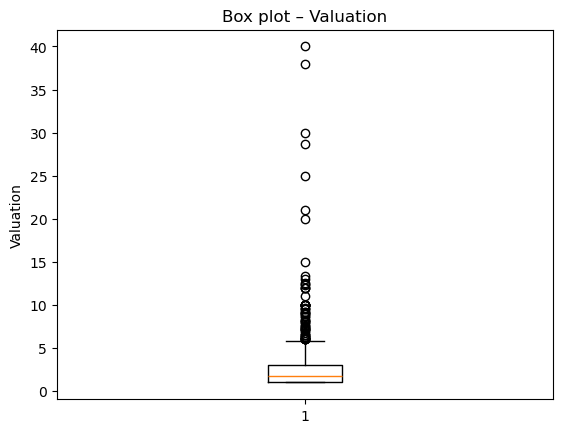

In [47]:
boxplot_cols(unicorn, ["Valuation"])

In [48]:
unicorn[unicorn["Valuation"] >= 15]

,Company,Valuation,Country,City,Industry,Year,Country_std
30,BYJU's,21.0,India,Bengaluru,Edtech,2017,India
42,Canva,40.0,Australia,Surry Hills,Internet software & services,2018,Australia
48,Nubank,30.0,Brazil,Sao Paulo,Fintech,2018,Brazil
86,Epic Games,28.7,United States,Cary,Other,2018,United States
104,Databricks,38.0,United States,San Francisco,Data management & analytics,2019,United States
110,Chime,25.0,United States,San Francisco,Fintech,2019,United States
236,goPuff,15.0,United States,Philadelphia,E-commerce & direct-to-consumer,2020,United States
363,J&T Express,20.0,Indonesia,Jakarta,"Supply chain, logistics, & delivery",2021,Indonesia


[skip] 'Valuation' not found in DataFrame


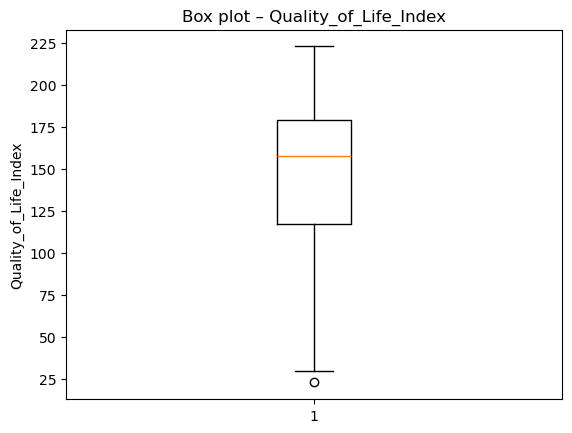

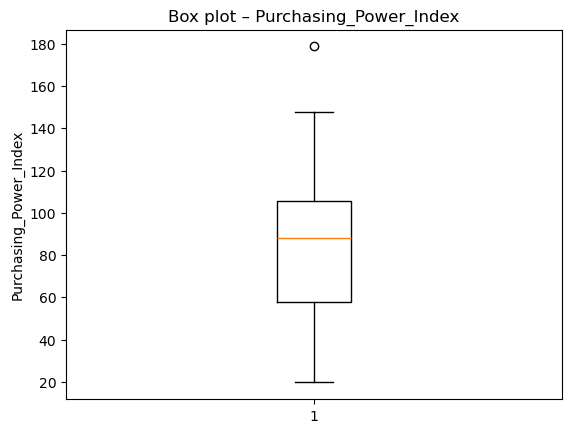

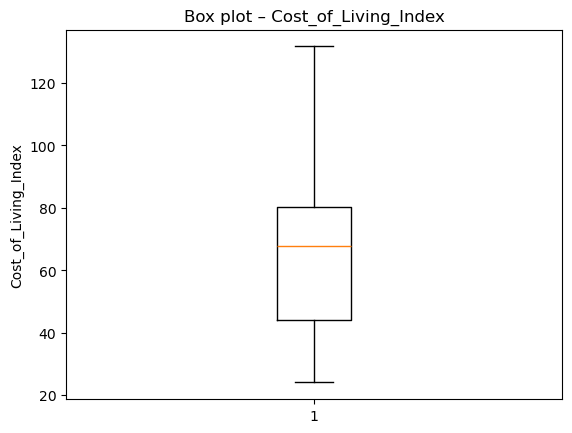

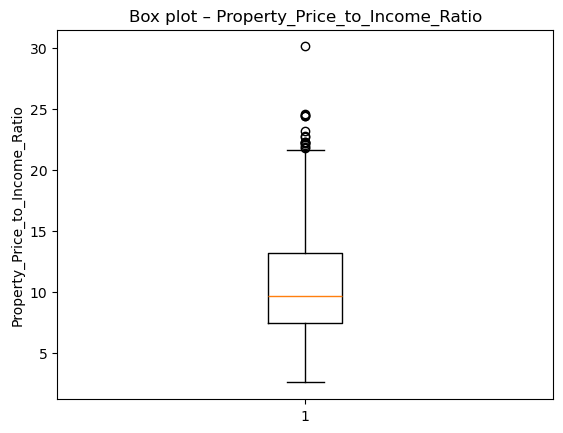

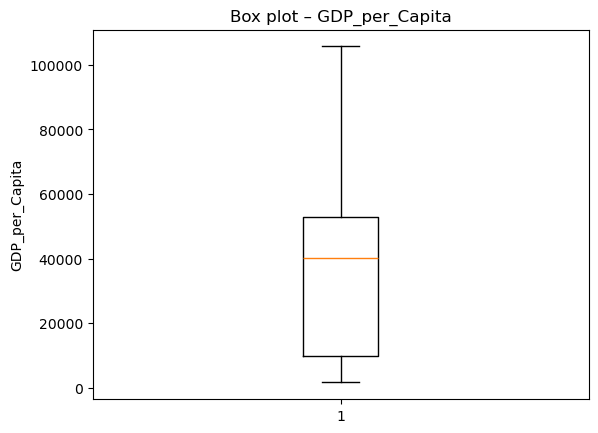

In [49]:
cols_to_check = ["Valuation", "Quality_of_Life_Index", "Purchasing_Power_Index", "Cost_of_Living_Index", "Property_Price_to_Income_Ratio", "GDP_per_Capita"]
boxplot_cols(qol_gdp, cols_to_check)

In [50]:
qol_gdp[(qol_gdp["Property_Price_to_Income_Ratio"] > 20) | (qol_gdp["Purchasing_Power_Index"] > 150)].sort_values(["Property_Price_to_Income_Ratio", "Purchasing_Power_Index"], ascending=False)

,Country,Quality_of_Life_Index,Purchasing_Power_Index,Cost_of_Living_Index,Property_Price_to_Income_Ratio,Year,GDP_per_Capita,Country_std
215,Philippines,78.4,19.7,40.7,30.1,2021,3484.385958,Philippines
183,Philippines,85.4,23.5,37.6,24.6,2020,3227.579102,Philippines
160,Argentina,115.3,47.2,33.0,24.5,2020,8535.599420,Argentina
61,Thailand,63.8,40.1,40.0,24.4,2016,5833.577101,Thailand
93,Thailand,57.2,34.3,43.7,24.4,2017,6413.091815,Thailand
56,Singapore,93.1,110.5,83.7,23.2,2016,57199.330206,Singapore
125,Thailand,101.2,38.6,48.9,22.8,2018,7099.775256,Thailand
192,Argentina,110.5,34.6,37.9,22.7,2021,10738.017960,Argentina
184,Singapore,144.4,89.0,81.1,22.3,2020,62184.900233,Singapore
189,Thailand,101.9,35.5,49.8,22.3,2020,6985.645229,Thailand


Adding ISO3 codes for countries

In [18]:
def country_to_iso3(name):
    try: return pycountry.countries.lookup(name).alpha_3
    except: return None

In [19]:
unicorn['ISO3'] = unicorn['Country_std'].apply(country_to_iso3)

Merge country shapes (Natural Earth)


In [20]:
world = gpd.read_file("../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp").to_crs(4326)
print(world.columns)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


In [21]:
import pyproj

countries_gdf = world[['ISO_A3','geometry']].rename(columns={'ISO_A3':'ISO3'})

unicorn_agg = (
    unicorn
      .groupby(["ISO3", "Country_std"], as_index=False)
      .agg(
          n_unicorns = ("ISO3", "size"),      # count
          total_val  = ("Valuation", "sum")   # sum
      )
)

unicorn_agg_geo = pd.merge(unicorn_agg, countries_gdf, on='ISO3', how='left')
unicorn_agg_gdf = gpd.GeoDataFrame(unicorn_agg_geo, geometry='geometry').to_crs(4326)
unicorn_agg_gdf.head()


,ISO3,Country_std,n_unicorns,total_val,geometry
0,ARE,United Arab Emirates,3,4.50,"POLYGON ((51.57952 24.2455, 51.75744 24.29407,..."
1,ARG,Argentina,1,2.45,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25 -5..."
2,AUS,Australia,6,50.60,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."
3,AUT,Austria,2,5.81,"POLYGON ((16.97967 48.1235, 16.90375 47.71487,..."
4,BEL,Belgium,2,7.55,"POLYGON ((6.15666 50.80372, 6.04307 50.12805, ..."


In [22]:
unicorn_agg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ISO3         32 non-null     object  
 1   Country_std  32 non-null     object  
 2   n_unicorns   32 non-null     int64   
 3   total_val    32 non-null     float64 
 4   geometry     29 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 1.4+ KB


Visualizing map for unicorn data

In [132]:
unicorn_agg_gdf.explore()

In [ ]:
unicorn_agg_gdf.geometry.isna().sum()

np.int64(3)

In [ ]:
geojson = json.loads(unicorn_agg_gdf[unicorn_agg_gdf.geometry.notna()].to_json())

fig = px.choropleth_map(
    unicorn_agg_gdf,
    geojson=geojson,
    locations="ISO3",                 # column in DataFrame
    featureidkey="properties.ISO3",   # identical path in GeoJSON
    color="total_val",
    hover_name="Country_std",
    hover_data={"n_unicorns": True, "total_val": ":,.2f"},
    zoom=1,
    center=dict(lat=20, lon=0),
    opacity=0.8,
    color_continuous_scale="Plasma",
    labels={"total_val": "Total Valuation ($B)", "n_unicorns": "# Unicorns"},
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.show()


Merge unicorn + QoL/GDP

In [108]:
merged = pd.merge(unicorn, qol_gdp, on='Country_std', how='left', suffixes=('_uni','_qol'))
merged.head()

,Company,Valuation,Country_uni,City,Industry,Year_uni,Country_std,ISO3,Country_qol,Quality_of_Life_Index,Purchasing_Power_Index,Cost_of_Living_Index,Property_Price_to_Income_Ratio,Year_qol,GDP_per_Capita
0,Red Ventures,1.0,United States,Fort Mill,Other,2015,United States,USA,United States,192.5,126.1,76.5,2.6,2015,56097.922641
1,Red Ventures,1.0,United States,Fort Mill,Other,2015,United States,USA,United States,184.0,139.2,74.1,3.4,2016,57126.635074
2,Red Ventures,1.0,United States,Fort Mill,Other,2015,United States,USA,United States,179.7,123.2,75.4,3.3,2017,59036.203767
3,Red Ventures,1.0,United States,Fort Mill,Other,2015,United States,USA,United States,180.6,127.6,73.0,3.3,2018,61650.844514
4,Red Ventures,1.0,United States,Fort Mill,Other,2015,United States,USA,United States,179.2,122.0,69.9,3.6,2019,63767.416820
